### Testing to see if Models will really be able to identify a large cohort of individual clusters

In [1]:
import pandas as pd
import numpy as np
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# datapath corresponnds to the path where the dataset is stored, 
# please go to the very first cell at the top and download the dataset and provide path to the stored location
datapath = "D:/Datasets/fifa19"
os.chdir(datapath)

In [3]:
df = pd.read_csv("data.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Photo", "Flag", "Club Logo", 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', "Loaned From", 'Real Face']

df.drop(columns=columns_to_drop, inplace = True)

In [5]:
# Taking first 1500 columns sorted on the basis of Overall, Potential, Special as it is easier to Plot.
df = df.sort_values(by = ["Overall", "Potential", "Special"], ascending = False).head(1500)

In [6]:
# Out of all 1500 players some players have some attributes not known as in the nan_players
nan_plyers = df[df.isnull().any(1)]

In [7]:
# dropping all the players from 1500 players who have one or the other attributes missing
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [8]:
# seggregating the attribute columns into different categories for easier handling

identity_features = ['Name', 'Nationality', 'Age', 'Club', 'Preferred Foot',
                     'Work Rate', 'Position', 'Joined',
                     'Contract Valid Until', 'Height', 'Weight']

money_features = ['Value', 'Wage', 'Release Clause']

attribute_features = ['Overall', 'Potential', 'Special', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Jersey Number', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

In [9]:
first = df[identity_features]
second = df[money_features]
third = df[attribute_features]

In [10]:
# Nationality mapping on the basis of their probability of occurence
nationality_counts = {country: count for country, count in zip(first["Nationality"].value_counts().index, first["Nationality"].value_counts().values)}
nationality_ratios = {country : np.round(count / 1406, 3) for country, count in nationality_counts.items()}

In [11]:
# Club Mapping on the basis of their probability of occurence
club_counts = {club: count for club, count in zip(first["Club"].value_counts().index, first["Club"].value_counts().values)}
club_ratios = {club : np.round(count / 1406, 3) for club, count in club_counts.items()}

In [12]:
# Preferred Foot Mapping on the basis of their probability of occurence
foot_counts = {foot : count for foot, count in zip(first["Preferred Foot"].value_counts().index, first["Preferred Foot"].value_counts().values)}
foot_ratios = {foot : np.round(count / 1406, 3) for foot, count in foot_counts.items()}

In [13]:
# Work Rate Mapping on the basis of their probability of occurence
work_counts = {work : count for work, count in zip(first["Work Rate"].value_counts().index, first["Work Rate"].value_counts().values)}
work_ratios = {work : np.round(count / 1406, 3) for work, count in work_counts.items()}

In [14]:
# Position Mapping on the basis of their probability of occurence
position_counts = {position : count for position, count in zip(first["Position"].value_counts().index, first["Position"].value_counts().values)}
position_ratios = {position : np.round(count / 1406, 3) for position, count in position_counts.items()}

In [15]:
def joined_year(rows):
    if len(rows["Joined"].split(",")) == 2:
        return rows["Joined"].split(",")[1]
    else:
        return np.nan

first["Joined Year"] = first.apply(joined_year, axis = "columns")
first["Contract Valid Until"] = first["Contract Valid Until"].astype(int)
first["Joined Year"] = first["Joined Year"].astype(int)
first["Years in Contract"] = first["Contract Valid Until"] - first["Joined Year"]

In [16]:
def convert_height(rows):
    """
    Converting the height which is in feet, inches to centimeter.
    1 feet = 30.48 centimeter
    1 inch = 2.54 centimeter
    """
    if len(rows["Height"].split("'")) == 2:
        return int(rows["Height"].split("'")[0]) * 30.48 + int(rows["Height"].split("'")[1]) * 2.54
    else:
        return np.nan

first["Height(cm)"] = first.apply(convert_height, axis = "columns")

In [17]:
def convert_weight(rows):
    """
    Converting the weight which is in pounds to Kgs.
    1 pound = 0.453592 kgs
    """
    if not pd.isnull(rows["Weight"]):
        return int(re.findall("[\d]+", rows["Weight"])[0]) * 0.453592
    else:
        return np.nan

first["Weight(kg)"] = first.apply(convert_weight, axis = "columns")

In [18]:
first["Nationality"] = first["Nationality"].map(nationality_ratios)
first["Club"] = first["Club"].map(club_ratios)
first["Preferred Foot"] = first["Preferred Foot"].map(foot_ratios)
first["Work Rate"] = first["Work Rate"].map(work_ratios)
first["Position"] = first["Position"].map(position_ratios)

In [19]:
columns_to_take = ['Nationality', 'Age', 'Club', 'Preferred Foot', 'Work Rate',
       'Position', 'Years in Contract', 'Height(cm)', 'Weight(kg)']

first = first[columns_to_take]

In [20]:
first["Nationality"] = first["Nationality"] * 50
first["Club"] = first["Club"] * 5

In [21]:
from sklearn.preprocessing import scale

scaled_first = scale(first, axis = 0)
scaled_first = pd.DataFrame(scaled_first, columns = columns_to_take)
abs_scaled_first = abs(scaled_first)

In [22]:
# Nationality, Height, Weight
from sklearn.manifold import TSNE
cols = ['Nationality', 'Height(cm)', 'Weight(kg)']

tsne = TSNE(n_components = 2)
tsne_data_one = tsne.fit_transform(scaled_first[cols])
tsne_data_two = tsne.fit_transform(abs_scaled_first[cols])

In [23]:
from sklearn.cluster import KMeans
K = range(1, 15)
inertias_one = []
inertias_two = []

for i in K:
    km = KMeans(n_clusters = i, random_state = 20)
    km.fit(tsne_data_one)
    inertias_one.append(km.inertia_)
    
    km.fit(tsne_data_two)
    inertias_two.append(km.inertia_)

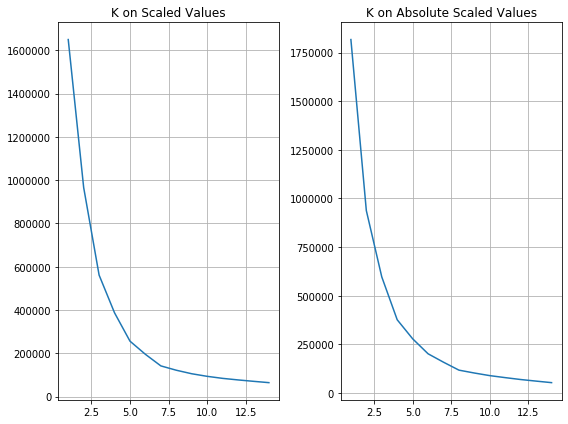

In [24]:
fig = plt.figure(figsize = (8, 6))

fig.add_subplot(1,2,1)
plt.plot(K, inertias_one)
plt.title("K on Scaled Values")
plt.grid()

fig.add_subplot(1,2,2)
plt.plot(K, inertias_two)
plt.title("K on Absolute Scaled Values")
plt.grid()

plt.tight_layout()
plt.show()

In [25]:
# Comparing the Model to identify that Model will be able to identify Players wrt their Countries

cols = ['Nationality', 'Height(cm)', 'Weight(kg)']
km = KMeans(n_clusters = 89)
km.fit(scaled_first[cols])

predictions = pd.DataFrame(km.predict(scaled_first[cols]), columns = ["Predictions"])
tsne_features = pd.DataFrame(tsne_data_one, columns = ["feature1", "feature2"])
tsne_df = pd.concat([tsne_features, predictions], axis = "columns")

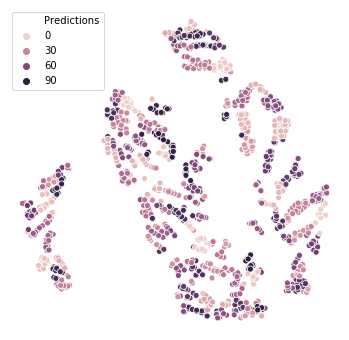

In [26]:
plt.figure(figsize = (6, 6))
sns.scatterplot(tsne_df["feature1"], tsne_df["feature2"], hue = tsne_df["Predictions"])
plt.axis("off")
plt.show()

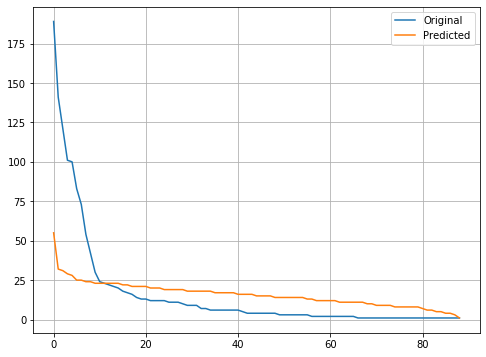

In [27]:
plt.figure(figsize = (8,6))
plt.plot(df["Nationality"].value_counts().values, label = "Original")
plt.plot(tsne_df["Predictions"].value_counts().values, label = "Predicted")
plt.legend()
plt.grid()
plt.show()

### Forming Clusters on the Qualities of Players

In [28]:
scaled_third = scale(third, axis = 0)
scaled_third = pd.DataFrame(scaled_third, columns = third.columns.values)
abs_scaled_third = abs(scaled_third)

tsne = TSNE(n_components = 2)
tsne_data_one = tsne.fit_transform(scaled_third)
tsne_data_two = tsne.fit_transform(abs_scaled_third)

In [29]:
from sklearn.cluster import KMeans
K = range(1, 15)
inertias_one = []
inertias_two = []
inertias_three = []
inertias_four = []

for i in K:
    km = KMeans(n_clusters = i, random_state = 20)
    
    km.fit(third)
    inertias_one.append(km.inertia_)
    
    km.fit(scaled_third)
    inertias_two.append(km.inertia_)
    
    km.fit(tsne_data_one)
    inertias_three.append(km.inertia_)
    
    km.fit(tsne_data_two)
    inertias_four.append(km.inertia_)

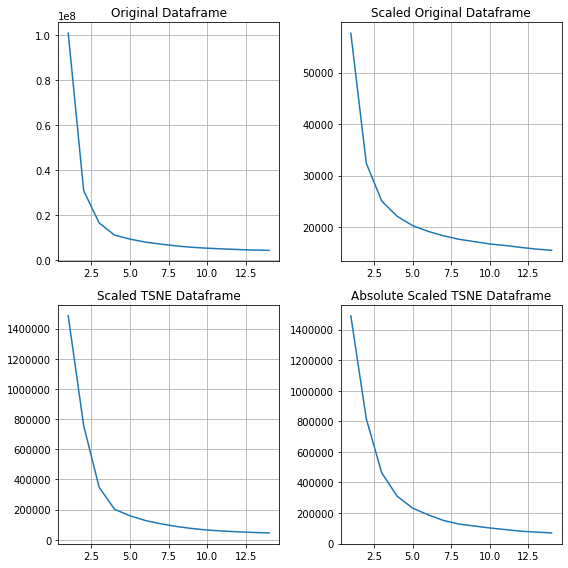

In [30]:
fig = plt.figure(figsize = (8, 8))

fig.add_subplot(2,2,1)
plt.plot(K, inertias_one)
plt.title("Original Dataframe")
plt.grid()

fig.add_subplot(2,2,2)
plt.plot(K, inertias_two)
plt.title("Scaled Original Dataframe")
plt.grid()

fig.add_subplot(2,2,3)
plt.plot(K, inertias_three)
plt.title("Scaled TSNE Dataframe")
plt.grid()

fig.add_subplot(2,2,4)
plt.plot(K, inertias_four)
plt.title("Absolute Scaled TSNE Dataframe")
plt.grid()

plt.tight_layout()
plt.show()

In [31]:
km = KMeans(n_clusters = 4)
km.fit(third)

predictions = pd.DataFrame(km.predict(third), columns = ["Predictions"])
tsne_features = pd.DataFrame(tsne_data_one, columns = ["feature1", "feature2"])
tsne_df = pd.concat([tsne_features, predictions], axis = "columns")

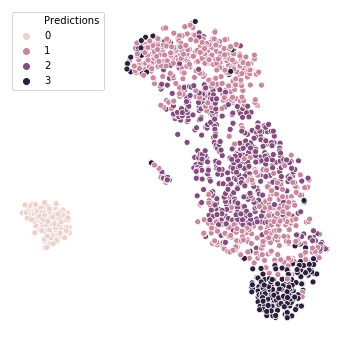

In [32]:
plt.figure(figsize = (6, 6))
sns.scatterplot(tsne_df["feature1"], tsne_df["feature2"], hue = tsne_df["Predictions"])
plt.axis("off")
plt.show()

In [33]:
km = KMeans(n_clusters = 4)
km.fit(scaled_third)

predictions = pd.DataFrame(km.predict(scaled_third), columns = ["Predictions"])
tsne_features = pd.DataFrame(tsne_data_one, columns = ["feature1", "feature2"])
tsne_df = pd.concat([tsne_features, predictions], axis = "columns")

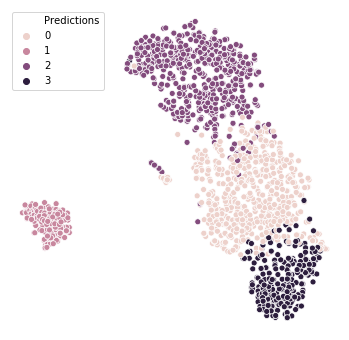

In [34]:
plt.figure(figsize = (6, 6))
sns.scatterplot(tsne_df["feature1"], tsne_df["feature2"], hue = tsne_df["Predictions"])
plt.axis("off")
plt.show()

### Forming Clusters on the Basis of their monetory features

In [35]:
def convert_currency(rows):
    if rows[-1] == "M":
        return float(rows[1:-1])
    elif rows[-1] == "K":
        return float(rows[1:-1]) / 1000000
    else:
        return np.nan

second["Value(Million)"] = second["Value"].apply(convert_currency)
second["Wage(Million)"] = second["Wage"].apply(convert_currency)
second["Release Clause(Million)"] = second["Release Clause"].apply(convert_currency)

In [36]:
cols = ["Value(Million)", "Wage(Million)", "Release Clause(Million)"]

scaled_second = scale(second[cols], axis = 0)
scaled_second = pd.DataFrame(scaled_second, columns = cols)
abs_scaled_second = abs(scaled_second)

tsne = TSNE(n_components = 2)
tsne_data_one = tsne.fit_transform(scaled_second)
tsne_data_two = tsne.fit_transform(abs_scaled_second)

In [37]:
from sklearn.cluster import KMeans
K = range(1, 15)
inertias_one = []
inertias_two = []
inertias_three = []
inertias_four = []

for i in K:
    km = KMeans(n_clusters = i, random_state = 20)
    
    km.fit(second[cols])
    inertias_one.append(km.inertia_)
    
    km.fit(scaled_second)
    inertias_two.append(km.inertia_)
    
    km.fit(tsne_data_one)
    inertias_three.append(km.inertia_)
    
    km.fit(tsne_data_two)
    inertias_four.append(km.inertia_)

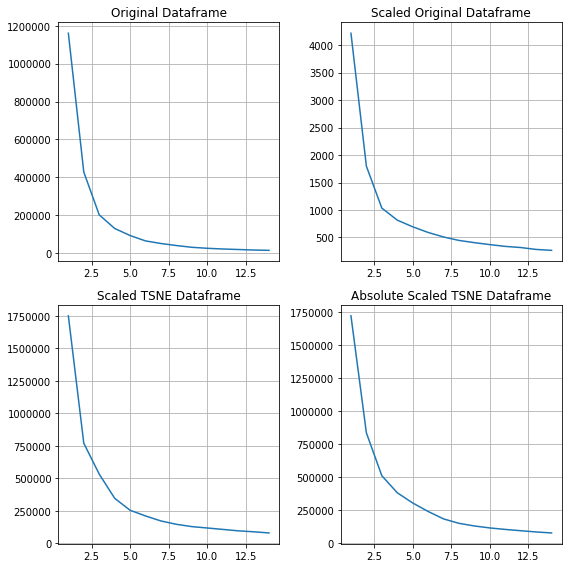

In [38]:
fig = plt.figure(figsize = (8, 8))

fig.add_subplot(2,2,1)
plt.plot(K, inertias_one)
plt.title("Original Dataframe")
plt.grid()

fig.add_subplot(2,2,2)
plt.plot(K, inertias_two)
plt.title("Scaled Original Dataframe")
plt.grid()

fig.add_subplot(2,2,3)
plt.plot(K, inertias_three)
plt.title("Scaled TSNE Dataframe")
plt.grid()

fig.add_subplot(2,2,4)
plt.plot(K, inertias_four)
plt.title("Absolute Scaled TSNE Dataframe")
plt.grid()

plt.tight_layout()
plt.show()

In [39]:
km = KMeans(n_clusters = 3)
km.fit(second[cols])

predictions = pd.DataFrame(km.predict(second[cols]), columns = ["Predictions"])
tsne_features = pd.DataFrame(tsne_data_one, columns = ["feature1", "feature2"])
tsne_df = pd.concat([tsne_features, predictions], axis = "columns")

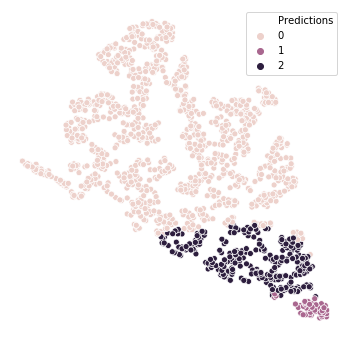

In [40]:
plt.figure(figsize = (6, 6))
sns.scatterplot(tsne_df["feature1"], tsne_df["feature2"], hue = tsne_df["Predictions"])
plt.axis("off")
plt.show()

In [41]:
km = KMeans(n_clusters = 3)
km.fit(scaled_second)

predictions = pd.DataFrame(km.predict(scaled_second), columns = ["Predictions"])
tsne_features = pd.DataFrame(tsne_data_one, columns = ["feature1", "feature2"])
tsne_df = pd.concat([tsne_features, predictions], axis = "columns")

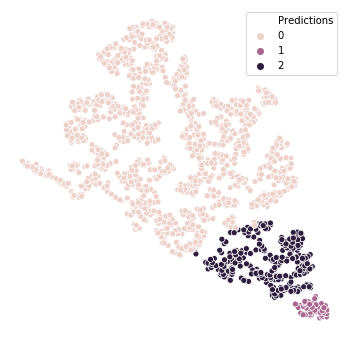

In [42]:
plt.figure(figsize = (6, 6))
sns.scatterplot(tsne_df["feature1"], tsne_df["feature2"], hue = tsne_df["Predictions"])
plt.axis("off")
plt.show()

In [54]:
temp = pd.concat([df, predictions], axis = "columns")
cols = ["Name", "Age", "Nationality", "Club", "Overall", "Value", "Wage", "Release Clause", "Predictions"]
temp = temp[cols]
temp.groupby(by = ["Predictions"]).aggregate("count")

,Name,Age,Nationality,Club,Overall,Value,Wage,Release Clause
Predictions,,,,,,,,
0,1126,1126,1126,1126,1126,1126,1126,1126
1,45,45,45,45,45,45,45,45
2,235,235,235,235,235,235,235,235


In [55]:
temp[temp["Predictions"] == 1]

,Name,Age,Nationality,Club,Overall,Value,Wage,Release Clause,Predictions
0,Cristiano Ronaldo,33,Portugal,Juventus,94,€77M,€405K,€127.1M,1
1,L. Messi,31,Argentina,FC Barcelona,94,€110.5M,€565K,€226.5M,1
2,Neymar Jr,26,Brazil,Paris Saint-Germain,92,€118.5M,€290K,€228.1M,1
3,De Gea,27,Spain,Manchester United,91,€72M,€260K,€138.6M,1
4,K. De Bruyne,27,Belgium,Manchester City,91,€102M,€355K,€196.4M,1
5,L. Suárez,31,Uruguay,FC Barcelona,91,€80M,€455K,€164M,1
6,L. Modrić,32,Croatia,Real Madrid,91,€67M,€420K,€137.4M,1
7,Sergio Ramos,32,Spain,Real Madrid,91,€51M,€380K,€104.6M,1
8,E. Hazard,27,Belgium,Chelsea,91,€93M,€340K,€172.1M,1
9,J. Oblak,25,Slovenia,Atlético Madrid,90,€68M,€94K,€144.5M,1
